In [21]:
import torch 
import umap 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt 
import seaborn as sbn 
from tkgdti.models.ComplEx2 import ComplEx2
import numpy as np 
import pandas as pd 

In [2]:
res = torch.load('/home/teddy/local/workflow_outputs/tkgdti/from_arc/results.pt', map_location='cpu', weights_only=False)

In [11]:
res['config']

{'optim': 'adam',
 'lr': 0.01,
 'wd': 0.0,
 'channels': 512,
 'batch_size': 10000,
 'n_epochs': 100,
 'lr_scheduler': False,
 'dropout': 0.0,
 'remove_relation_idx': None}

In [13]:
data = torch.load('/home/teddy/local/workflow_outputs/tkgdti/from_arc/Data.pt', map_location='cpu', weights_only=False)

In [ ]:
model = ComplEx2(data, hidden_channels=res['config']['channels'], scale_grad_by_freq=False, dtype=torch.float32, dropout=0.)
model.load_state_dict(res['best_model'])
model.eval()

ComplEx2(
  (head_embedding_real_dict): ModuleDict(
    (disease): Embedding(4723, 512)
    (drug): Embedding(89, 512)
    (gene): Embedding(16565, 512)
    (pathway): Embedding(2363, 512)
  )
  (head_embedding_imag_dict): ModuleDict(
    (disease): Embedding(4723, 512)
    (drug): Embedding(89, 512)
    (gene): Embedding(16565, 512)
    (pathway): Embedding(2363, 512)
  )
  (tail_embedding_real_dict): ModuleDict(
    (disease): Embedding(4723, 512)
    (drug): Embedding(89, 512)
    (gene): Embedding(16565, 512)
    (pathway): Embedding(2363, 512)
  )
  (tail_embedding_imag_dict): ModuleDict(
    (disease): Embedding(4723, 512)
    (drug): Embedding(89, 512)
    (gene): Embedding(16565, 512)
    (pathway): Embedding(2363, 512)
  )
  (relation_real_embedding): Embedding(31, 512)
  (relation_imag_embedding): Embedding(31, 512)
)

In [69]:
z_gene_real = model.head_embedding_real_dict['gene'].weight.data.detach().cpu().numpy() 
z_gene_imag = model.head_embedding_imag_dict['gene'].weight.data.detach().cpu().numpy()  

z_gene = np.concatenate([z_gene_real, z_gene_imag], axis=1) 

z_dis_real = model.head_embedding_real_dict['disease'].weight.data.detach().cpu().numpy() 
z_dis_imag = model.head_embedding_imag_dict['disease'].weight.data.detach().cpu().numpy() 

z_dis = np.concatenate([z_dis_real, z_dis_imag], axis=1) 

z_pathway_real = model.head_embedding_real_dict['pathway'].weight.data.detach().cpu().numpy() 
z_pathway_imag = model.head_embedding_imag_dict['pathway'].weight.data.detach().cpu().numpy() 

z_pathway = np.concatenate([z_pathway_real, z_pathway_imag], axis=1) 

z_drug_real = model.head_embedding_real_dict['drug'].weight.data.detach().cpu().numpy() 
z_drug_imag = model.head_embedding_imag_dict['drug'].weight.data.detach().cpu().numpy() 

z_drug = np.concatenate([z_drug_real, z_drug_imag], axis=1) 

z = np.concatenate([z_gene, z_dis, z_pathway, z_drug], axis=0)  


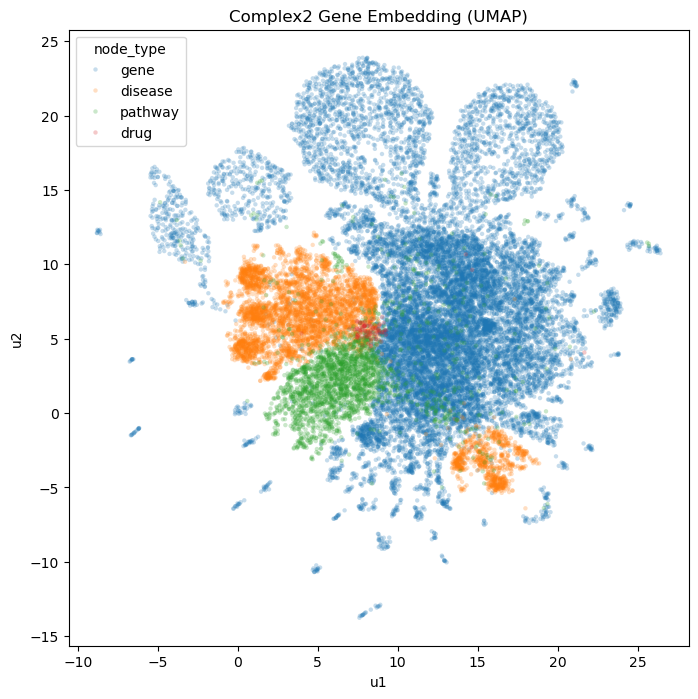

In [104]:
reducer = umap.UMAP(n_components=2, metric='cosine', n_neighbors=10,
                    min_dist=1., spread=1.0, n_epochs=1000)
#reducer = TSNE(n_components=2, perplexity=100)
u = reducer.fit_transform(z) 

df = pd.DataFrame(u, columns=['u1', 'u2'], 
                        index=data.node_name_dict['gene'].tolist() \
                            + data.node_name_dict['disease'].tolist() \
                                + data.node_name_dict['pathway'].tolist() \
                                    + data.node_name_dict['drug'].tolist())

df = df.assign(node_type = ['gene']*len(data.node_name_dict['gene']) \
                + ['disease']*len(data.node_name_dict['disease']) \
                    + ['pathway']*len(data.node_name_dict['pathway']) \
                        + ['drug']*len(data.node_name_dict['drug']))

plt.figure(figsize=(8, 8))
sbn.scatterplot(data=df, x='u1', y='u2', linewidth=0, alpha=0.25, s=10, hue='node_type')
plt.title('Complex2 Gene Embedding (UMAP)')
plt.show() 

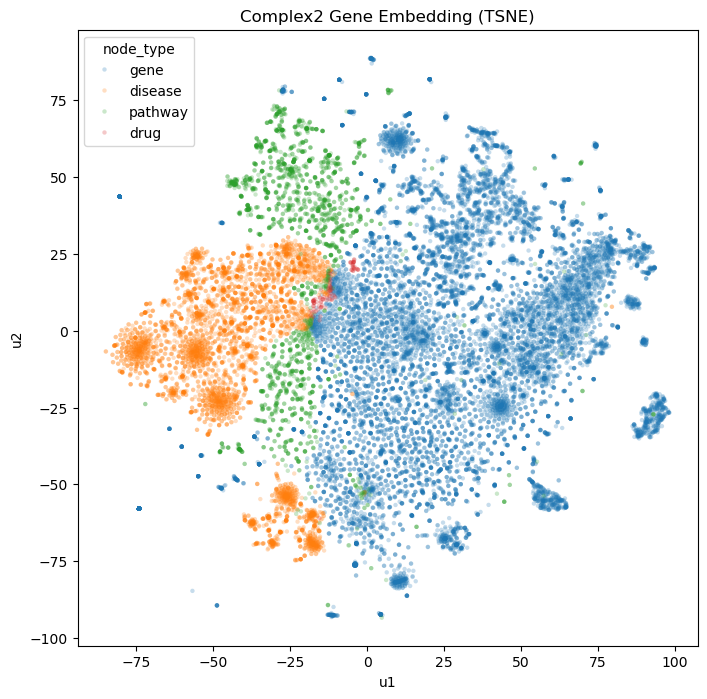

In [106]:
reducer = TSNE(n_components=2, perplexity=50, metric='cosine')
u = reducer.fit_transform(z) 

df = pd.DataFrame(u, columns=['u1', 'u2'], 
                        index=data.node_name_dict['gene'].tolist() \
                            + data.node_name_dict['disease'].tolist() \
                                + data.node_name_dict['pathway'].tolist() \
                                    + data.node_name_dict['drug'].tolist())

df = df.assign(node_type = ['gene']*len(data.node_name_dict['gene']) \
                + ['disease']*len(data.node_name_dict['disease']) \
                    + ['pathway']*len(data.node_name_dict['pathway']) \
                        + ['drug']*len(data.node_name_dict['drug']))

plt.figure(figsize=(8, 8))
sbn.scatterplot(data=df, x='u1', y='u2', linewidth=0, alpha=0.25, s=10, hue='node_type')
plt.title('Complex2 Gene Embedding (TSNE)')
plt.show() 

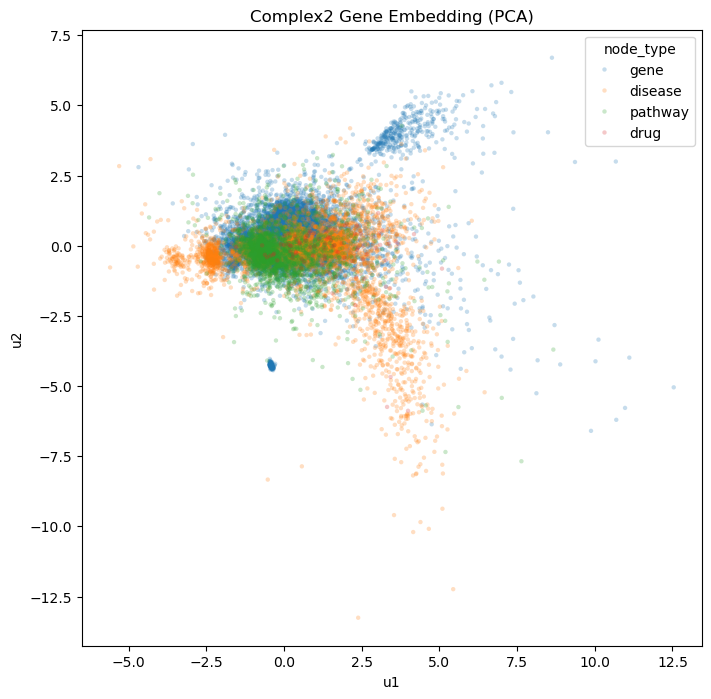

In [102]:
reducer = PCA(n_components=2)
u = reducer.fit_transform(z) 

df = pd.DataFrame(u, columns=['u1', 'u2'], 
                        index=data.node_name_dict['gene'].tolist() \
                            + data.node_name_dict['disease'].tolist() \
                                + data.node_name_dict['pathway'].tolist() \
                                    + data.node_name_dict['drug'].tolist())

df = df.assign(node_type = ['gene']*len(data.node_name_dict['gene']) \
                + ['disease']*len(data.node_name_dict['disease']) \
                    + ['pathway']*len(data.node_name_dict['pathway']) \
                        + ['drug']*len(data.node_name_dict['drug']))

plt.figure(figsize=(8, 8))
sbn.scatterplot(data=df, x='u1', y='u2', linewidth=0, alpha=0.25, s=10, hue='node_type')
plt.title('Complex2 Gene Embedding (PCA)')
plt.show() 

In [116]:
rel_names = ['->'.join(x) for x in data.edge_reltype.keys()]

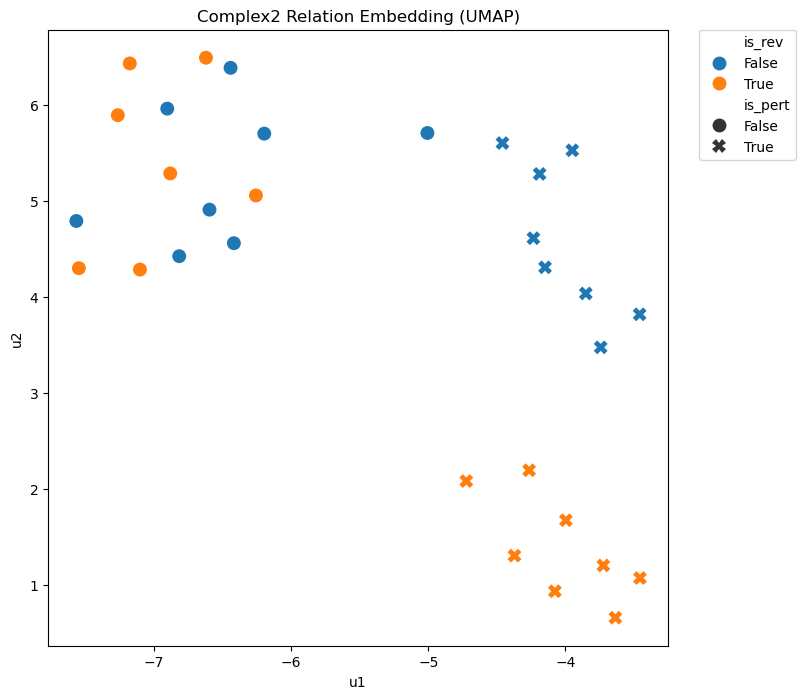

In [130]:
z_rel_real = model.relation_real_embedding.weight.data.detach().cpu().numpy() 
z_rel_imag = model.relation_imag_embedding.weight.data.detach().cpu().numpy() 

z_rel = np.concatenate([z_rel_real, z_rel_imag], axis=1) 

reducer = umap.UMAP(n_components=2, metric='cosine', n_neighbors=5,
                    min_dist=0.1, spread=1.0, n_epochs=2000)


u = reducer.fit_transform(z_rel) 

df = pd.DataFrame(u, columns=['u1', 'u2']).assign(rel_name=rel_names)
df = df.assign(is_pert = lambda x: x.rel_name.str.contains('perturbation'))
df = df.assign(is_rev = lambda x: x.rel_name.str.contains('rev'))

plt.figure(figsize=(8, 8))
sbn.scatterplot(data=df, x='u1', y='u2', linewidth=0, alpha=1.0, s=100, hue='is_rev', style='is_pert')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title('Complex2 Relation Embedding (UMAP)')
plt.show() 


